**ограниченная машина Больцмана (RBM): ассоциативная память**

Евгений Борисов <esborisov@sevsu.ru>

Ассоциативная память на основе ограниченной машины Больцмана (RBM).   
http://mechanoid.su/neural-net-boltzman-restr.html

##  загружаем данные 

In [1]:
!ls data

abc-29x29.pkl.gz  numb-30x30.pkl.gz  test_u.txt.gz
ideal_u.txt.gz	  pix-17x31.pkl.gz


In [2]:
import pickle
import gzip

# with gzip.open('data/numb-30x30.pkl.gz','rb') as f: data = pickle.load(f)
with gzip.open('data/abc-29x29.pkl.gz','rb') as f: data = pickle.load(f)    

In [3]:
data['test'].keys()

dict_keys(['2d', '3d'])

In [4]:
data_train = data['train']['data']
data_test = data['test']['2d']['data']
# data_test = data['test']['noise_lo']['data']

del data

In [5]:
import numpy as np
from numpy import random as rng

In [6]:
import matplotlib.pyplot as plt

def plot_images(data,ncols=17):
    nrows = int(np.ceil(len(data)/ncols))
    figsize=(ncols,nrows)
    fig, ax = plt.subplots( nrows, ncols, figsize=figsize)
    
    if nrows>1:
        for r in range(nrows): 
            for c in range(ncols): 
                ax[r,c].axis('off')
                if (r*ncols+c < len(data)): 
                    ax[r,c].imshow(data[r*ncols+c]) #,cmap='GnBu')
        return
    
    for c in range(ncols): 
        ax[c].axis('off')
        if (c < len(data)): 
            ax[c].imshow(data[c]) #,cmap='GnBu')        

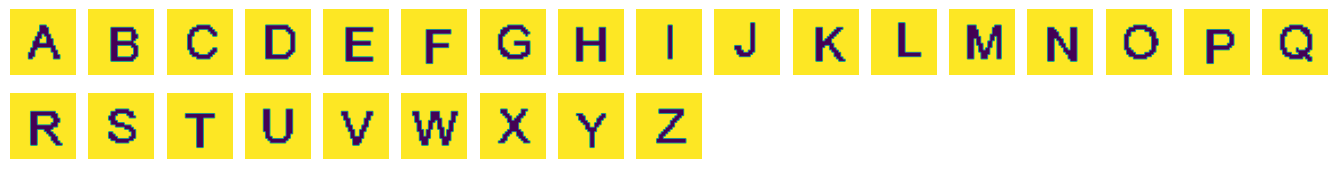

In [7]:
plot_images( data_train )

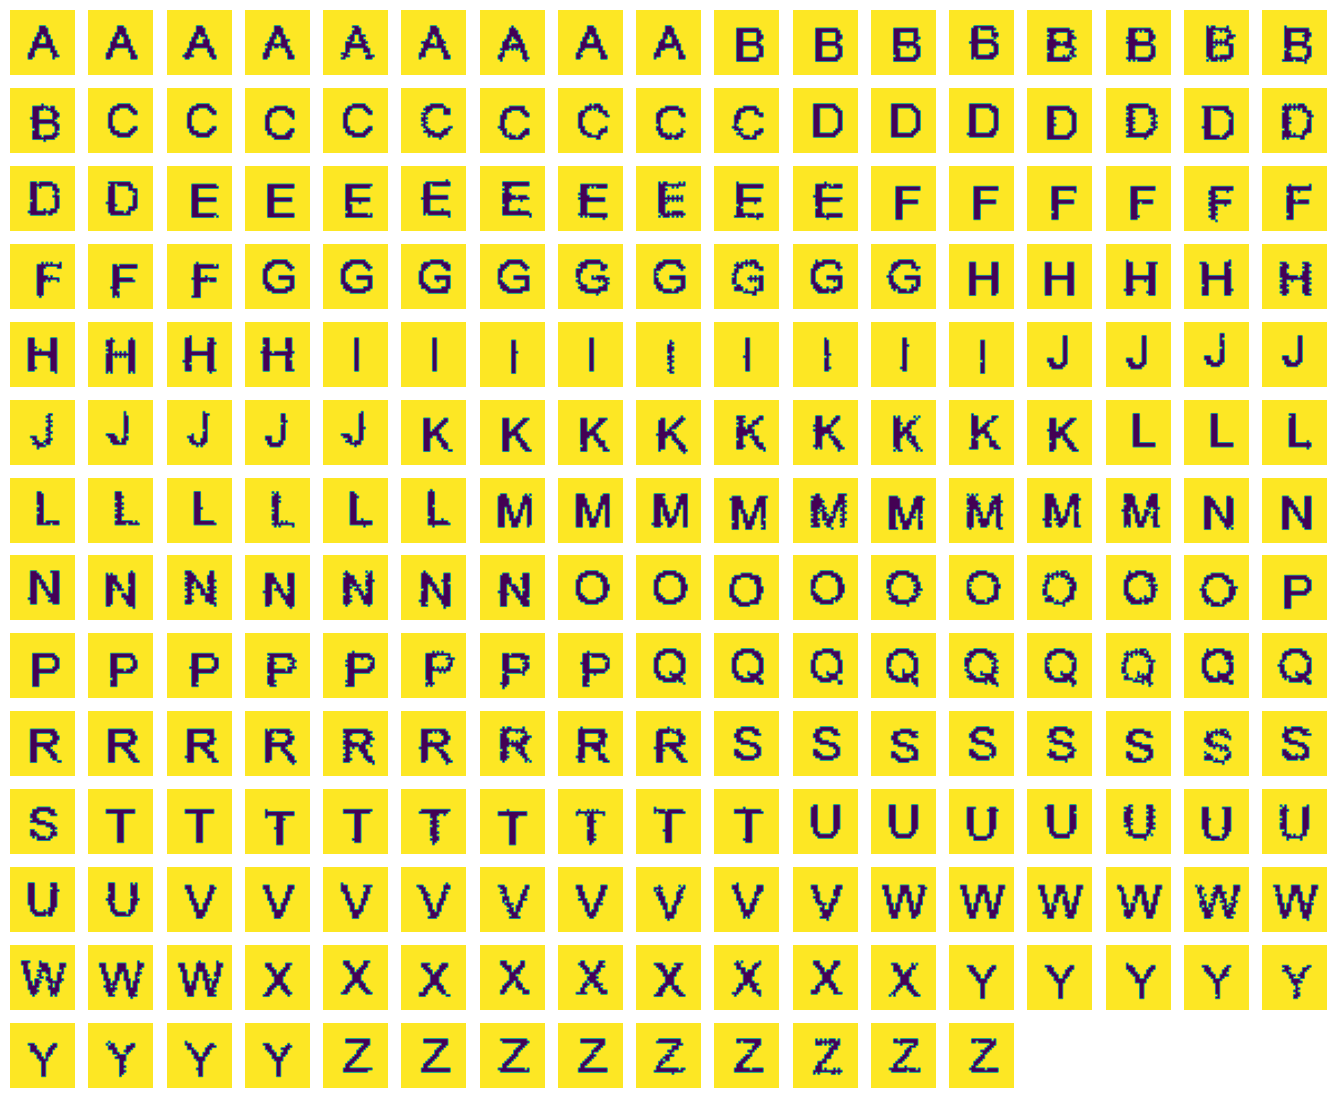

In [8]:
plot_images(data_test)

## формируем датасет

In [9]:
n,w,h = data_train.shape
x_train = ( (data_train<(data_train.max()/2)).astype(float) ).reshape(n,w*h)

n,w,h = data_test.shape
x_test = ( (data_test<(data_test.max()/2)).astype(float) ).reshape(n,w*h)

display(( x_train.shape, x_test.shape, ))

((26, 841), (234, 841))

In [10]:
# n,w,h = data_train.shape
# x_train = np.sign( 255.-data_train ).reshape(n,w*h)

# n,w,h = data_test.shape
# x_test = np.sign( 255.-data_test ).reshape(n,w*h)

# display(( x_train.shape, x_test.shape, ))

# модель

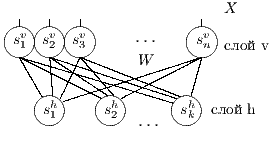

In [11]:
class RBM:
    
    def __init__(self,v_size,h_size):
        self._weight = rng.normal(size=(v_size,h_size))
        self._bias_h = np.zeros(shape=(1,h_size))
        self._bias_v = np.zeros(shape=(1,v_size))
    
    def forward(self,x,max_iter=128,min_delta=1e-4):
        v = x
        for n in range(max_iter):
            v_ = v # сохраняем состояние
            _,v = self._forward_step(v) # переходим в новое состояние
            # если состояние не изменилось то завершаем
            if self._msqe(v,v_)<min_delta: break
        return n,v        
    
    def _forward_step(self,x):
        batch_size, v_size = x.shape
        _,h_size = self._bias_h.shape
        
        p_h = self.sigmoid( x.dot(self._weight) - self._bias_h )
        h = ( rng.rand(batch_size,h_size)<p_h ).astype(float)
        
        p_v = self.sigmoid( h.dot(self._weight.T) - self._bias_v )
        v = ( rng.rand(batch_size,v_size)<p_v ).astype(float)
                
        return h,v
    
    def forward_train(self,x,steps=2):
        visible = [x]
        hidden = []
        for n in range(steps):
            h,v = self._forward_step(visible[-1]) # переходим в новое состояние
            visible.append(v)
            hidden.append(h)
        return np.stack(hidden),np.stack(visible)
     
    @staticmethod
    def sigmoid(x):
        return 1./(1.+np.exp(-x))
    
    @property
    def weight(self):
        return self._weight, self._bias_h, self._bias_v 
        
    @weight.setter
    def weight(self,w): 
        self._weight = w[0]
        self._bias_h = w[1]
        self._bias_v = w[2]
        return self
    
    def _msqe(self,t,o):
        d = t-o
        return (d*d).mean()

In [12]:
model = RBM(v_size=x_train.shape[1],h_size=128)
n,o = model.forward(x_train)
display( n, o.shape )

h,v = model.forward_train(x_train)
display( h.shape, v.shape )

127

(26, 841)

(2, 26, 128)

(3, 26, 841)

In [13]:
from tqdm.auto import tqdm

In [14]:
class TrainRBM:
        
    def __init__(self,model):
        self._model = model
        self._lr = 1e-1
        self._mu = 0.
        self._rho = 0.
        
        self._dw  = 0.
        self._dbh = 0.
        self._dbv = 0.
    
    def fit(self,x,batch_size,n_epoch=2,lr=1e-1,mu=0.,rho=.0,min_loss=1e-5):
        assert len(x)>1
        assert (0<batch_size<(len(x)+1))
        self._lr = lr
        self._mu = mu
        self._rho = rho
                
        loss_history = []
        for _ in tqdm(range(n_epoch)):
            self._fit_epoch(x,batch_size)
            loss_history.append( self._loss(x) )
            if loss_history[-1]<min_loss: break
                
        return loss_history, self._model
    
    def _fit_epoch(self,x,batch_size):
        for x in self._get_batch(x,batch_size):
            self._fit_batch(x)
        return self
        
    def _fit_batch(self,x):
        h,v = self._model.forward_train(x)
        dw,dbh,dbv = self._gradient(h,v)
        self._weight_ajust(dw,dbh,dbv)
        return self
        
        
    def _gradient(self,h,v):
        dw = v[0].T.dot(h[0]) - v[1].T.dot(h[1])
        dbv = (v[0]-v[1]).mean(axis=0)
        dbh = (h[0]-h[1]).mean(axis=0)
        return self._norm_weigth(dw,dbh,dbv)
    
    def _norm_weigth(self,w,bv,bh):
        wm = np.abs(np.hstack([w.flatten(),bv.flatten(),bh.flatten()])).max()
        wm = wm if wm==0. else 1.
        return w/wm,bv/wm,bh/wm
    
    def _weight_ajust(self,dw,dbh,dbv):
        w,bh,bv = self._model.weight
        
        self._dw  = self._lr*(dw + self._rho*w) +  self._mu * self._dw
        self._dbh = self._lr*(dbh + self._rho*bh) + self._mu * self._dbh
        self._dbv = self._lr*(dbv + self._rho*bv) + self._mu * self._dbv 
        
        self._model.weight = (
            w  + self._dw,
            bh + self._dbh,
            bv + self._dbv,
        )
        
        return self
                
    
    # генератор батчей
    def _get_batch(self,x,batch_size): 
        n_samples = len(x) # количество учебных пар
        batch_count = np.ceil( n_samples/batch_size).astype(int) # количество батчей
        # перемешиваем учебный набор и режем его на батчи
        for idx in np.array_split(rng.permutation(n_samples), batch_count ):
            yield x[idx,:]

    def _loss(self,target):
        _,predicted = self._model.forward(target)
        d = (target-predicted)
        return (d*d).mean()


# загружаем память модели

In [15]:
loss_history, model = TrainRBM(
        model = RBM(v_size=x_train.shape[1],h_size=512)
    ).fit(
        x_train,
        n_epoch=256*2, 
        batch_size=len(x_train)//2, 
        lr=1e-2,
        rho=1e-2,
        mu=4e-1,
        min_loss=1e-4,
    )

  0%|          | 0/512 [00:00<?, ?it/s]

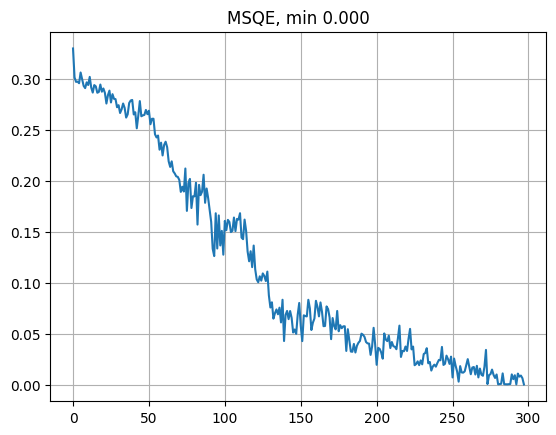

In [16]:
fig,ax = plt.subplots()
ax.plot( loss_history )
ax.set_title(f'MSQE, min {min(loss_history):.3f}')
ax.grid()

# тестируем

In [17]:
# model.weight

In [26]:
# n,o = model.forward(x_train)
# display(n)

In [21]:
# (w,h),n = data_train[0].shape,len(data_train)
# o_ = ((1-o.reshape(n,w,h))*127).astype(np.uint8)

In [27]:
# plot_images(data_train)
# plot_images(o_)

In [23]:
n,o = model.forward(x_test)
display(n)

127

In [24]:
(w,h),n = data_test[0].shape,len(data_test)
o_ = ((1-o.reshape(n,w,h))*127).astype(np.uint8)

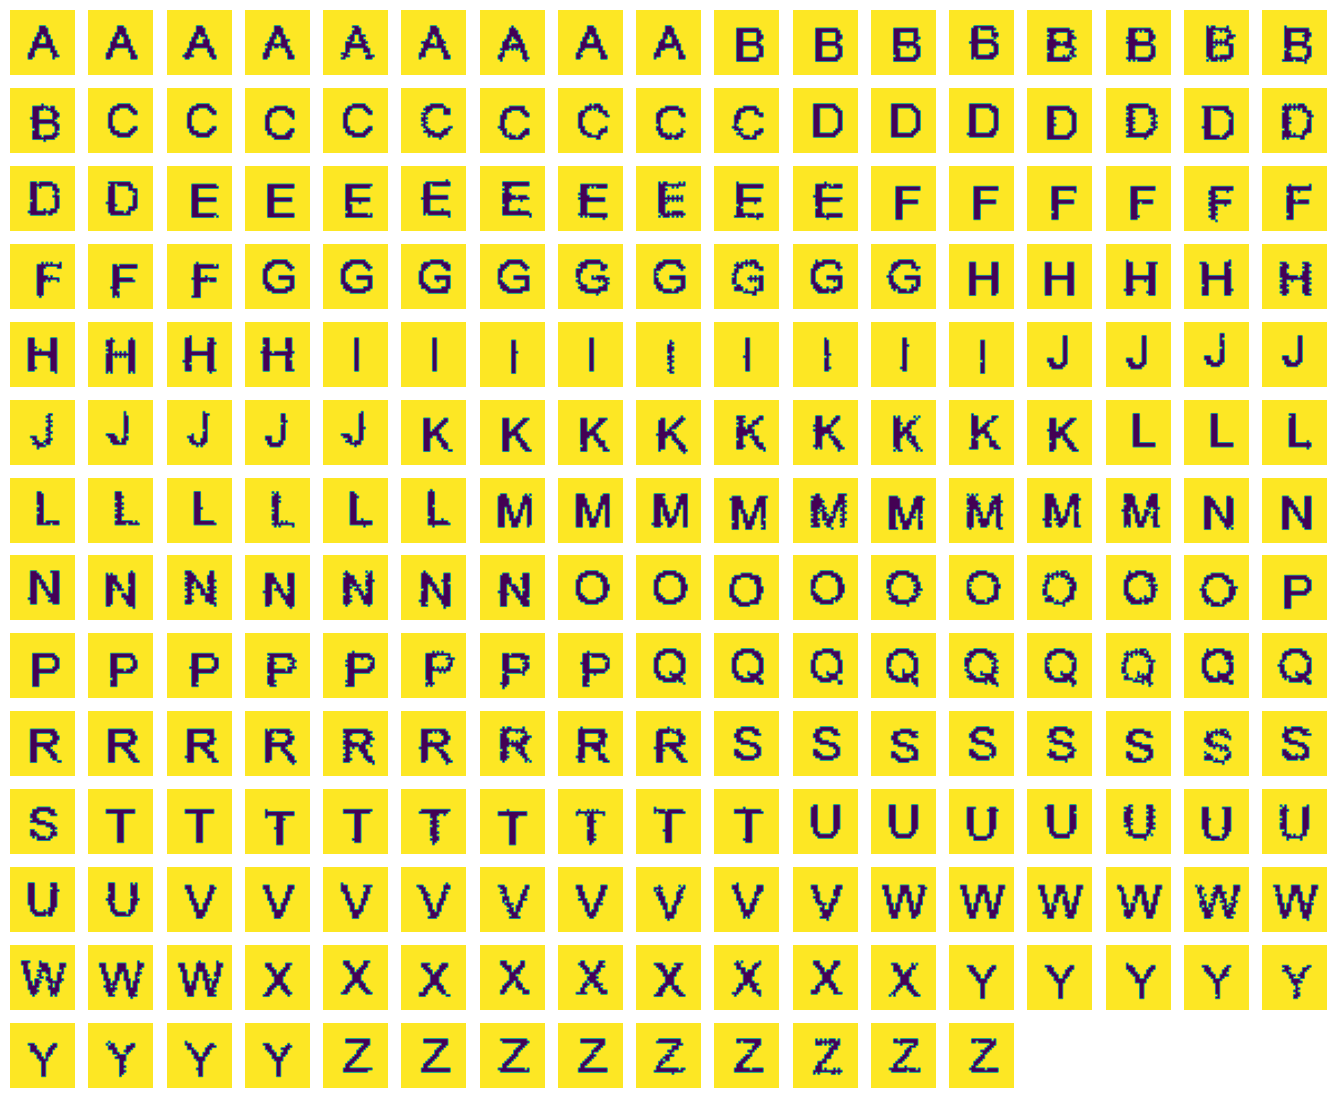

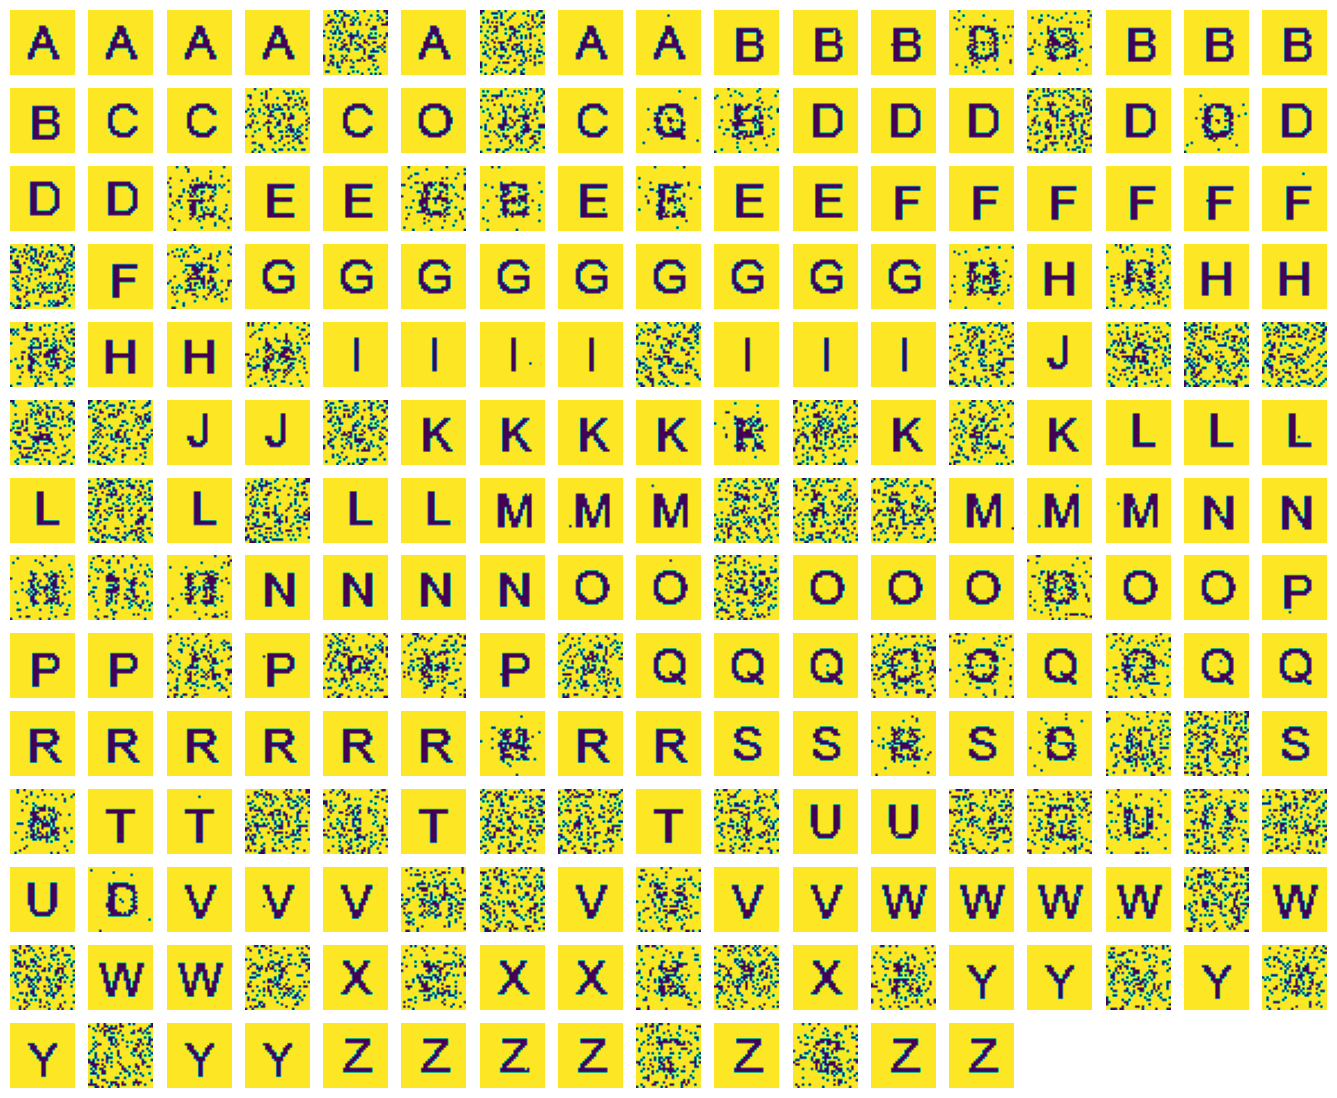

In [25]:
plot_images(data_test)
plot_images(o_)